# Case_study_6_2

In this case we can find a closed form solution of the non-smooth
problem by forming every block of variables with a single variable.
The Lasso problem has the following form:
$$
\min_{{\bf{x}}} \frac{1}{n}\left\Vert {\bf{A}}{\bf{x}}-{\bf{b}}\right\Vert _{2}^{2}+\lambda\left\Vert {\bf{x}}\right\Vert _{1}
$$

Having in mind the form of the solution

$$
Prox_{\eta f}\left(z^{i}\right)=soft\left(z^{i},\lambda \eta \right)
$$

So finally, we get:

$$\begin{align}
 w_j &&= \frac{{\bf{X}}_{:,j}^T\left({\bf{y}} - {\bf{X}}_{:,-j}{\bf{w}}_{-j}\right)}{{\bf{X}}_{:,j}^T{\bf{X}}_{:,j}} - \frac{n\lambda \text{sgn}(w_j)}{2{\bf{X}}_{:,j}^T{\bf{X}}_{:,j}}\\
&&= \text{Soft}\left( \frac{{\bf{X}}_{:,j}^T\left({\bf{y}} - {\bf{X}}_{:,-j}{\bf{w}}_{-j}\right)}{{\bf{X}}_{:,j}^T{\bf{X}}_{:,j}}, \frac{n\lambda}{2{\bf{X}}_{:,j}^T{\bf{X}}_{:,j}}\right)
\end{align}$$

In [ ]:
!wget --no-cache -O init.py -q https://raw.githubusercontent.com/jdariasl/OTBD/main/content/init.py
import init; init.init(force_download=False)

In [1]:
from local.lib.Generation import scenarios_regression
from local.lib.utils import solver_cvx, grad_FOM, grad_SOM, grad_FOM_decay, bcd_lasso, ista_lasso, fista_lasso, eval_loss, plot_surface
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
#!pip install cvxpy

In [ ]:
import cvxpy as cp

In [2]:
# Loading scenarios
# ===========================
scenario=4
data_class, set_up =scenarios_regression(scenario)


# Definition of the problem
#===================================
loss_fn = lambda n, X, Y, w: (1/n)*cp.pnorm(X @ w - Y, p=2)**2
reg_L1 = lambda w: cp.pnorm(w, p=1)
loss_lasso = lambda n, X, Y, w, lambd: loss_fn(n, X, Y, w) + lambd * reg_L1(w)

subgrad_lasso = lambda n, X, Y, w, lambd: (2/n)*X.T@(X@w-Y)+lambd*np.sign(w)
grad_LS = lambda n, X, Y, w, lambd: (2/n)*X.T@(X@w-Y);


# Solution of the empirical risk using CVX
#=========================================
w_lasso_cvx=solver_cvx(set_up,loss_lasso)

w = cp.Variable(w_lasso_cvx.shape[0])
w.value = w_lasso_cvx 
loss_opt=loss_lasso(set_up['Niter_train'],set_up['Xtrain'][:,:set_up['d']+1],set_up['ytrain'][:,0],w,set_up['Lambda']).value

# Gradient descent
out_subgd =grad_FOM(set_up,subgrad_lasso)
out_subgd_decay =grad_FOM_decay(set_up,subgrad_lasso)

loss_subgrad=eval_loss(out_subgd,set_up,loss_lasso)
loss_subgrad_decay=eval_loss(out_subgd_decay,set_up,loss_lasso)

out_ista=ista_lasso(set_up,grad_LS)
out_fista=fista_lasso(set_up,grad_LS)

loss_ista=eval_loss(out_ista,set_up,loss_lasso)
loss_fista=eval_loss(out_fista,set_up,loss_lasso)
                                                          
# FLEXA algorithm for lasso
out_bcd =bcd_lasso(set_up);
out_bcd2=np.c_[out_bcd[:,1:set_up['Number_iter_BCD']],np.kron(out_bcd[:,set_up['Number_iter_BCD']].reshape(-1,1),np.ones((1,set_up['Niter_train']-set_up['Number_iter_BCD']+1)))]
loss_bcd=eval_loss(out_bcd2,set_up,loss_lasso)

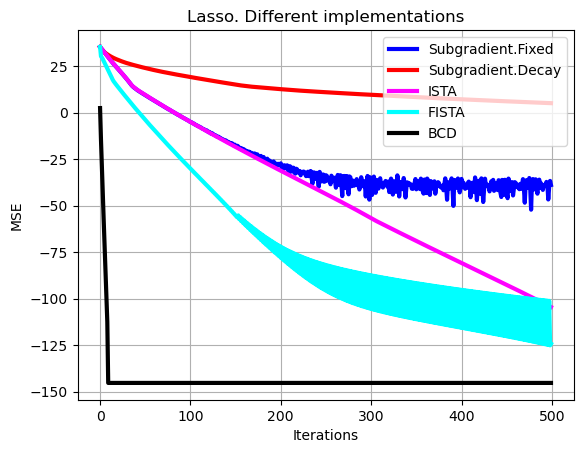

In [3]:
# Plot of learning curves
plt.plot(np.arange(0,set_up['Niter_train']),10*np.log10(np.sum((loss_subgrad-loss_opt*np.ones((1,set_up['Niter_train'])))**2,axis=0)),color='b', linewidth = 3, label = 'Subgradient.Fixed')
plt.plot(np.arange(0,set_up['Niter_train']),10*np.log10(np.sum((loss_subgrad_decay-loss_opt*np.ones((1,set_up['Niter_train'])))**2,axis=0)),color='r', linewidth = 3, label = 'Subgradient.Decay')
plt.plot(np.arange(0,set_up['Niter_train']),10*np.log10(np.sum((loss_ista-loss_opt*np.ones((1,set_up['Niter_train'])))**2,axis=0)),color='magenta', linewidth = 3, label = 'ISTA'),
plt.plot(np.arange(0,set_up['Niter_train']),10*np.log10(np.sum((loss_fista-loss_opt*np.ones((1,set_up['Niter_train'])))**2,axis=0)),color='cyan', linewidth = 3, label = 'FISTA')
plt.plot(np.arange(0,set_up['Niter_train']),10*np.log10(np.sum((loss_bcd-loss_opt*np.ones((1,set_up['Niter_train'])))**2,axis=0)),color='black', linewidth = 3, label = 'BCD')
plt.xlabel('Iterations')
plt.ylabel('MSE')
plt.grid()
plt.legend(loc='upper right')
plt.title('Lasso. Different implementations')
plt.show()

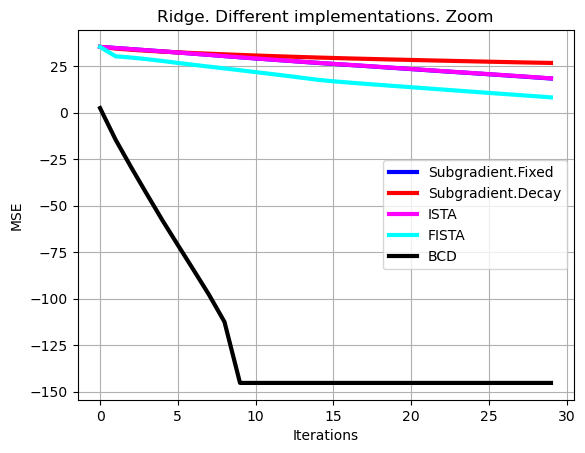

In [4]:
# Let's make a zoom
# Plot of learning curves
show=30
plt.plot(np.arange(0,show),10*np.log10(np.sum((loss_subgrad[0,:show]-loss_opt*np.ones((1,show)))**2,axis=0)),color='b', linewidth = 3, label = 'Subgradient.Fixed')
plt.plot(np.arange(0,show),10*np.log10(np.sum((loss_subgrad_decay[0,:show]-loss_opt*np.ones((1,show)))**2,axis=0)),color='r', linewidth = 3, label = 'Subgradient.Decay')
plt.plot(np.arange(0,show),10*np.log10(np.sum((loss_ista[0,:show]-loss_opt*np.ones((1,show)))**2,axis=0)),color='magenta', linewidth = 3, label = 'ISTA')
plt.plot(np.arange(0,show),10*np.log10(np.sum((loss_fista[0,:show]-loss_opt*np.ones((1,show)))**2,axis=0)),color='cyan', linewidth = 3, label = 'FISTA')
plt.plot(np.arange(0,show),10*np.log10(np.sum((loss_bcd[0,:show]-loss_opt*np.ones((1,show)))**2,axis=0)),color='black', linewidth = 3 , label = 'BCD')
plt.xlabel('Iterations')
plt.ylabel('MSE')
plt.grid()
plt.legend()
plt.title('Ridge. Different implementations. Zoom')
plt.show()